# Tutorial 6: LiDAR point clouds

This tutorial follows from [LiDAR waveforms](5_lidar_waveforms.ipynb), and demonstrates some inspection and analysis tasks using Python. We will:

- read ASPRS LAS format files, a common data exchange format
- examine some points derived from LiDAR
- interpolate points into a mesh or grid
- evalauate our results

It uses the following technical concepts:

- reading LAS files using LASpy
- array manipulation in Numpy
- organising irregularly-spaced data into grids
- exporting data for inspection in third-party applications (eg [QGIS](http://qgis.org))

In this tutorial there's a lot of repeated code for making plots. You can function-ify it if you like, or leave it as-is.

### New Python parts

You'll need the `LASpy` and `Rasterio` python libraries for this tutorial.

### Tutorial workflow

This tutorial is designed as a 'walk through' - you don't have to invent any code yourself, you can step through the notebook and run everything as-is. It does not dive into LASpy functionality - it uses LASpy as a convenience method for reading and interrogating LAS format data.

Please feel free to modify plots, and use the data and methods shown here to try different analyses or visualisations.

Also, feel free to suggest better (where better == simpler and easier to explain) methods for any of the tutorial sections you see here. If something is not clear, please say so.

## Set up our toolbox

In [1]:
# First, set up a python environment with all the tools we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
import scipy

# here are the two new libraries for this tutorial
import laspy
import rasterio

# we only use Seaborn to set a style for our plots - if you don't have it, it's safe to leave out
import seaborn as sns 

#set some plotting parameters
sns.set_style('darkgrid')

%matplotlib inline

## Working with LAS files

LAS is a standard file format maintained by the American Society for Photogrammetry and Remote Sensing (ASPRS - http://asprs.org). The LAS standard is developed iteratively - and in 2018, always comes as `1.x`, where `1` is the **major version** and `.x` is the **minor version**. These currently run from 1 to 4. LAS `1.2` is very common, with LAS `1.4` becoming more prevalent - as this iteration (LAS 1.4 (https://www.asprs.org/wp-content/uploads/2010/12/LAS_1_4_r13.pdf) is also an Open Geospatial Consortium (OGC) community standard for the storage and exchange of LiDAR data.

Within each LAS format specification, there are numerous **point format** specifications - these define the types of data the LAS file is capable of holding. For example, LAS 1.4 point format 6 is capable of holding different data attributes (or *dimensions*) for each point than, say LAS 1.4 point format 2. This is outlined in the LAS specification document given above. It's not critical knowledge for this tutorial - something to hold in the back of your mind for later!

The short and simple version is that LAS files are structured to hold a metadata record (header), and an un-indexed array of coordinates and attributes. This is a throwback to how data were collected when the format was first developed - data are collected as a stream of time-stamped attributes, and dumped into a file in time order.

We'll see that structure in action as we inspect data - we can split out headers and inspect those, before diving into the data. Unlike rasterised data, we *are not able to* index into the data using grid coordinates (for example data[X,Y] ) - because the data are not stored in a regular grid!

We are still able to filter data by it's attributes - to reduce data to only points we want to work with. A few different approaches to selecting data will be used - but nothing outside of Numpy array indexing you've already come across.

## Sample datasets

In this workshop we'll use two different types of data - from airborne and ground based sensors. A public dropbox link will be provided in the workshop, from which you need to download two files: `Airborne.las` and `zebedee-georef-hag.las`

#### Airborne data

`Airborne.las` is a small chunk of an airborne survey collected in 2013 over Mulligan's flat woodland.  


#### Ground-based data

`zebedee-georef-hag.las` is an entire handheld laser scanner survey. It is also preprocessed such that all 'heights' in the data are height relative to ground.


## Interrogating an ASPRS LAS file with LASpy

In this section we'll open and examine an ASPRS LAS file using LASpy: https://laspy.readthedocs.io

First, we'll inspect some LAS header information, then get into the point data itself.

In [65]:
# read a LAS file into an array-like object with LASpy
# change the path '../data' to wherever you saved 'Airborne.las'

airborne_data = laspy.file.File('../data/Airborne.las', mode = 'r')

In [66]:
for spec in airborne_data.point_format:
    print(spec.name)

X
Y
Z
intensity
flag_byte
raw_classification
scan_angle_rank
user_data
pt_src_id
gps_time


## Metadata

Let's see what metadata we can extract about our file before we need to process anything

In [67]:
# extract and examine the LAS header information

airborne_header = airborne_data.get_header()

In [68]:
#what things are contained in the LAS header? This will return all of the available fields in a LAS header
# NOT necessarily fields which contain data...

for spec in airborne_data.header.header_format:
    print(spec.name)

file_sig
file_source_id
global_encoding
proj_id_1
proj_id_2
proj_id_3
proj_id_4
version_major
version_minor
system_id
software_id
created_day
created_year
header_size
data_offset
num_variable_len_recs
data_format_id
data_record_length
point_records_count
point_return_count
x_scale
y_scale
z_scale
x_offset
y_offset
z_offset
x_max
x_min
y_max
y_min
z_max
z_min


### Reading metadata

Metadata attributes can be read by accessing properties of the header object, with some examples below.

**Note** we're using LASpy convenience functions to extract metadata, rather than directly interrogating the data. Try typing `airborne_header.` then pressing `tab` to see what options are available:

In [69]:
# what LAS format 'minor version' is this file? Recall that in 2018, all LAS data has 'major version' of 1.

airborne_header.minor_version

2

In [70]:
# What point format
airborne_header.dataformat_id

1

In [71]:
# how many points are in this dataset?

airborne_header.get_count()

107424

In [72]:
# What are it's spatial bounds?

airborne_header.max

[698719.99, 6106639.99, 661.45]

In [73]:
airborne_header.min

[698638.0, 6106569.0, 642.36]

In [74]:
# what are the dimensions of the 3D box the data occupy?

box_dimensions = np.array(airborne_header.max[:]) - np.array(airborne_header.min[:])
print('Size in metres of the 3D region containing the data: X {} Y {} Z {}'.format(box_dimensions[0],
                                                                                  box_dimensions[1],
                                                                                  box_dimensions[2]))

Size in metres of the 3D region containing the data: X 81.98999999999069 Y 70.99000000022352 Z 19.090000000000032


### Using metadata to estimate point density

Now that we can figure out the area covered by the data, and also the total number of points, we can estimate point density as (npoints/area).

This number might not be true of all regions in the data - in some places there will be more points per unit, in other places there will be fewer.

In [75]:
airborne_header.get_count() / (box_dimensions[0]*box_dimensions[1]) 


18.45624118912216

## Point data

Now, we get to the list of 3D points contained in the data.

In [76]:
# what attributes can be stored for each point?

for spec in airborne_data.point_format:
    print(spec.name)

X
Y
Z
intensity
flag_byte
raw_classification
scan_angle_rank
user_data
pt_src_id
gps_time


In [77]:
# Let's have a look at the actual array of points we get from LASpy.
# you can see actual point values in an array-of-arrays, with their 'dimension' labels in a 'dtype' array
# Note that coordinates (X,Y,Z) are stored as integers - a scale factor defined in the header is used to convert
# them to floating point coordinates when they are read out.

airborne_data.points

array([((69871633, 610656902, 64382, 126, 73, 2,  8, 87, 209, 70431420.72506654),),
       ((69871637, 610656905, 64384, 140, 73, 2,  8, 87, 209, 70431420.72507417),),
       ((69871642, 610656910, 64379, 136, 73, 2,  8, 87, 209, 70431420.7250818 ),),
       ...,
       ((69871553, 610663999, 65499,  36, 73, 5, -5, 87, 215, 70432714.02390563),),
       ((69871400, 610663990, 64350,  13, 82, 2, -5, 87, 215, 70432714.02392852),),
       ((69871411, 610663999, 64353,  14, 82, 2, -5, 87, 215, 70432714.02395129),)],
      dtype=[('point', [('X', '<i4'), ('Y', '<i4'), ('Z', '<i4'), ('intensity', '<u2'), ('flag_byte', 'u1'), ('raw_classification', 'u1'), ('scan_angle_rank', 'i1'), ('user_data', 'u1'), ('pt_src_id', '<u2'), ('gps_time', '<f8')])])

### Do our data have labels?

LiDAR is commonly classified - or labelled - on a per-point basis to show whether it is a gound return, a tree, a building or some other feature of the world. Our point data can store classifications (`raw_classifications`). Let's see if our data actually carry any labels

[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9')]

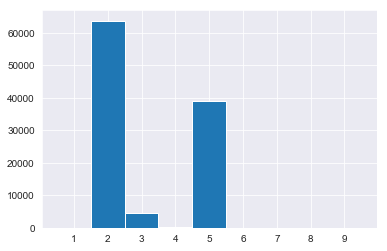

In [78]:
# Do the points have associated labels (classifications)? 
# Extra points - why did we not just query the data storage schema from the header?
# What would this histogram show if the data were unclassified

#create 10 bins labelled 1 to 10
class_hist_bins = np.arange(1, 11, 1)
width = np.array([class_hist_bins[i+1]-class_hist_bins[i] for i in range(len(class_hist_bins)-1)])
ind = np.array(class_hist_bins[:-1])

#create the histogram plot
fig, ax = plt.subplots()
n, bins, patches = plt.hist(airborne_data.Classification, bins=class_hist_bins)
ax.set_xticks(ind + width/2)
ax.set_xticklabels(class_hist_bins)

We can see that we have a few classifications (or labels) here:
- class 2: ground
- class 3: low vegetation
- class 5: tall trees

As we head through this workshop, we'll use that information to find out more about the forest the data contains.

But we don't know what the data look like yet! Let's fix that

#### Technical note

If you're looking at the line of code above where we define `width` and wonder what's going on - it uses a Python convenience method called a [list comprehension](https://docs.python.org/3/tutorial/datastructures.html#list-comprehensions). They're super handy - and beyond the scope of this workshop. 

## Plot the data for inspection

Now, we want to extract the spatial components of our dataset. These are stored in LAS files as 'X, Y, and Z', which are integers. LASpy provides a convenience method to scale the data to floating point numbers representing coordinates in real space - which we call as `airborne_data.x` (lower case) for the X coordinate (and so on).

Text(0, 0.5, 'Elevation (metres)')

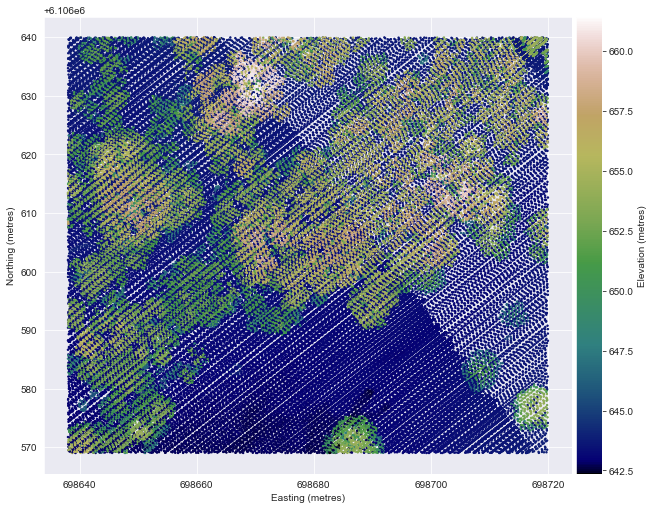

In [79]:
# in 2D, coloured by elevation
plt.figure(figsize=(10,10))
plt.scatter(airborne_data.x,
            airborne_data.y,
            c=airborne_data.z,
            cmap='gist_earth',
            s=2)
plt.axis('equal')

# label the axes
plt.xlabel('Easting (metres)')
plt.ylabel('Northing (metres)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Elevation (metres)')

Text(0.5, 0, 'Elevation (metres)')

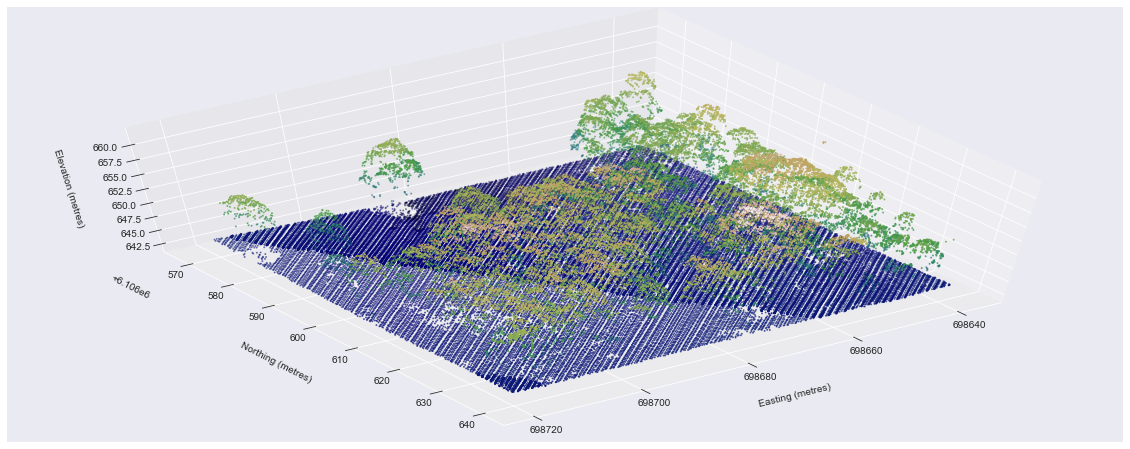

In [80]:
# in 3D, again coloured by elevation
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(airborne_data .x,
           airborne_data.y,
           airborne_data.z,
           c=airborne_data.z,
           s=1, cmap='gist_earth')
ax.view_init(60, 55)

# label the axes
ax.set_xlabel('Easting (metres)', labelpad=25)
ax.set_ylabel('Northing (metres)', labelpad=25)
ax.set_zlabel('Elevation (metres)', labelpad=15)

#### A quick note on XYZ and East, North, Elevation

In this workshop we're so far using X,Y,Z and Easting, Northing, Elevation interchangeably to describe the same dimensions:

- `X == Easting`
- `Y == Northing`
- `Z == Elevation, or Up`

(noting that `==` means 'is equal to').

The airborne dataset we've just plotted is expressed in a real-world projected coordinate system ( GDA94 / MGA Zone 54, often shortcut to [EPSG:28355](spatialreference.org:8092/ref/epsg/gda94-mga-zone-55/)) - which can essentially can be described as an XYZ system. This is great for small areas and makes life simpler for us.

**Where might this approach fall down? Is the earth really flat?**

Finally, the LAS header for Airborne.las doesn't contain any information about it's reference system. How can we safely infer one?

Text(0.5, 0, 'Elevation (metres)')

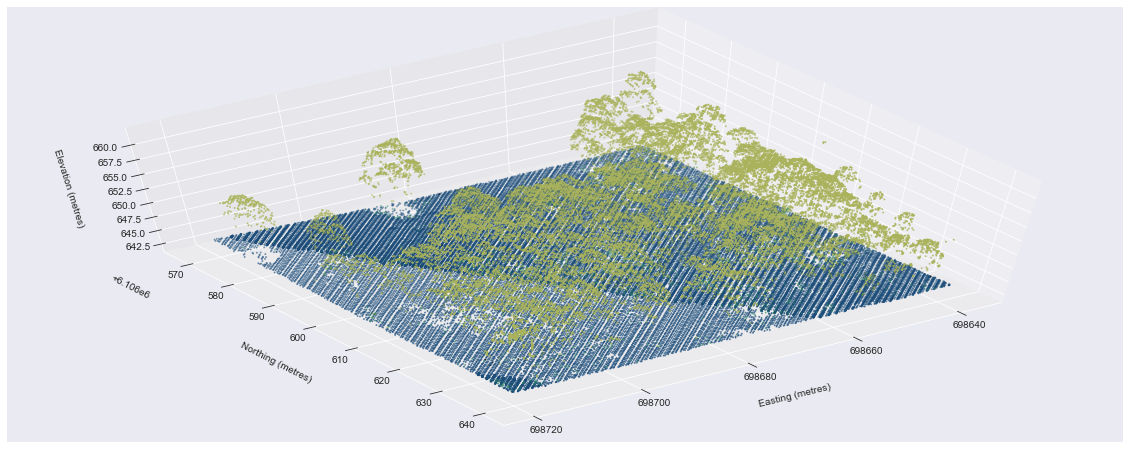

In [81]:
# in 3D, again coloured by classification
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(airborne_data .x,
           airborne_data.y,
           airborne_data.z,
           c=airborne_data.Classification,
           s=1, cmap='gist_earth')
ax.view_init(60, 55)

# label the axes
ax.set_xlabel('Easting (metres)', labelpad=25)
ax.set_ylabel('Northing (metres)', labelpad=25)
ax.set_zlabel('Elevation (metres)', labelpad=15)

## Measure tree heights

In this exercise we'll create a ground map, and a tree map - to compute tree heights. We can do this relatively easily because our data arrived pre-labelled. The simplest approach here is to grid the data, interpolate 'ground points' where none exist, and then subtract those values from tree heights.

We're creating what is commonly called a 'Height Above Ground' or 'Normalised height' map.

### Extract ground points

Let's look at just the ground. How are these data different from the 'final return' dataset we looked at in the LiDAR waveform workshop? Are they only 'final returns' or has something else happened?


#### Technical note

In order to extract labelled subsets of data, we're using `np.where` to create an index which we can use to search or dataset for points with characteristics we like (in this case `Classification == something`). We can do this in two steps, first creating a variable containng the index and then applying it:

```
index = np.where(airborne_data.Classification == 2)
x_ground = airborne_data.x[index]
```

...however, Numpy gives us a convenience method - using `np.where` to create indexes on the fly, so we use it - see the next cell for an example:

In [19]:
x_ground = airborne_data.x[np.where(airborne_data.Classification == 2)]
y_ground = airborne_data.y[np.where(airborne_data.Classification == 2)]
z_ground = airborne_data.z[np.where(airborne_data.Classification == 2)]

Text(0, 0.5, 'Elevation (metres)')

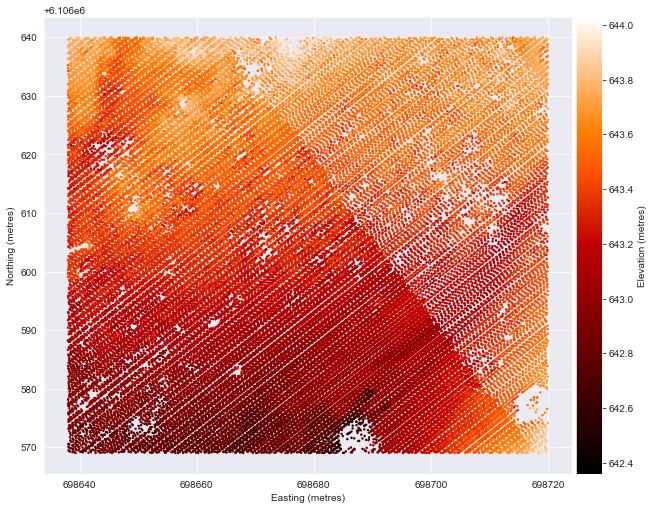

In [20]:
# in 2D, coloured by elevation
plt.figure(figsize=(10,10))
plt.scatter(x_ground,
            y_ground,
            c=z_ground,
            cmap='gist_heat',
            s=2)
plt.axis('equal')

# label the axes
plt.xlabel('Easting (metres)')
plt.ylabel('Northing (metres)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Elevation (metres)')

Text(0.5, 0, 'Elevation (metres)')

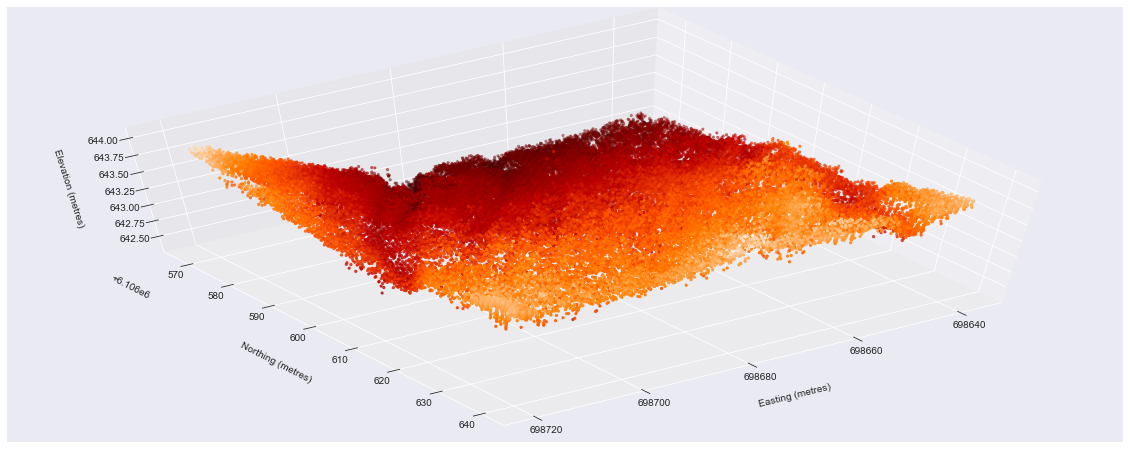

In [21]:
# in 3D
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_ground,
           y_ground,
           z_ground,
           c=z_ground,
           s=5, cmap='gist_heat')
ax.view_init(60, 55)

# label the axes
ax.set_xlabel('Easting (metres)', labelpad=25)
ax.set_ylabel('Northing (metres)', labelpad=25)
ax.set_zlabel('Elevation (metres)', labelpad=15)

### Extract trees

Now we'll look at just the trees.

In [22]:
x_trees = airborne_data.x[np.where(airborne_data.Classification == 5)]
y_trees = airborne_data.y[np.where(airborne_data.Classification == 5)]
z_trees = airborne_data.z[np.where(airborne_data.Classification == 5)]

Text(0, 0.5, 'Elevation (metres)')

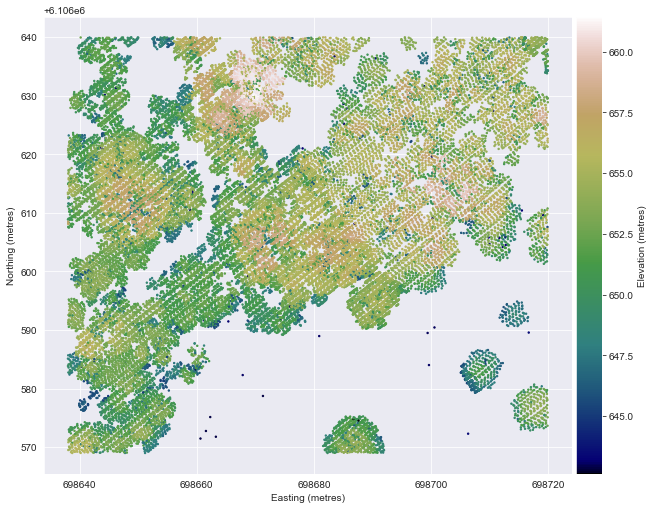

In [23]:
# in 2D, coloured by elevation
plt.figure(figsize=(10,10))
plt.scatter(x_trees,
            y_trees,
            c=z_trees,
            cmap='gist_earth',
            s=2)
plt.axis('equal')

# label the axes
plt.xlabel('Easting (metres)')
plt.ylabel('Northing (metres)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Elevation (metres)')

Text(0.5, 0, 'Elevation (metres)')

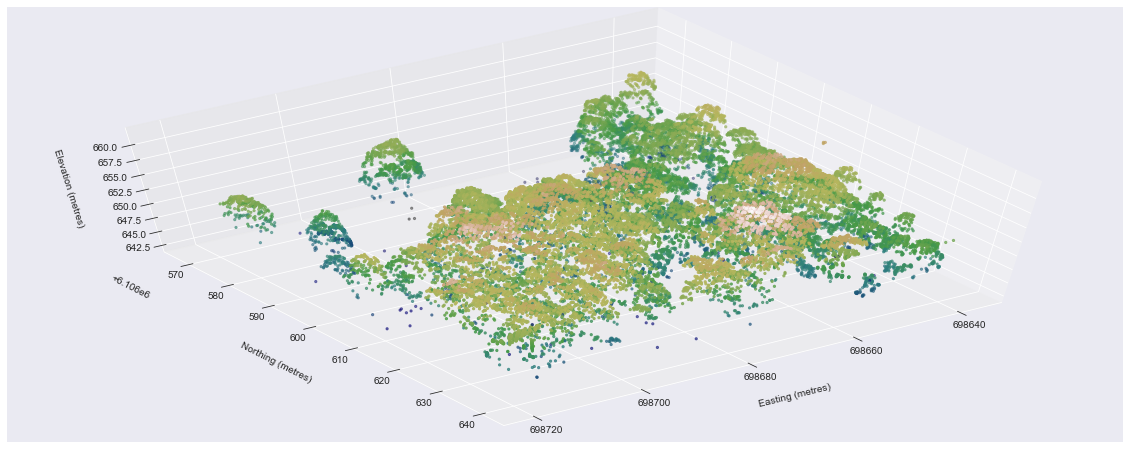

In [24]:
# Plot in 3D
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_trees,
           y_trees,
           z_trees,
           c=z_trees,
           s=5, cmap='gist_earth')
ax.view_init(60, 55)

# label the axes
ax.set_xlabel('Easting (metres)', labelpad=25)
ax.set_ylabel('Northing (metres)', labelpad=25)
ax.set_zlabel('Elevation (metres)', labelpad=15)

### Interpolate ground under the trees

There is not always a ground return under trees - so we need to invent them. In this example, we will:

- grid trees and ground on to a common grid using Numpy's 2D histogram (see a great explanation here: http://chris35wills.github.io/gridding_data/)
- in those grids, generate 'ground' where no ground points exist in a cell - so that for every tree cell, we hav a ground cell. 

In [25]:
# choose a grid resolution in metres
cellsize = 0.5

In [26]:
# bin point into a 2D grid - using a 2D histogram!

# how many bins in X and Y?
x_bins=int(np.ceil(box_dimensions[0]+1) * (1/cellsize))
y_bins=int(np.ceil(box_dimensions[1]+1) * (1/cellsize))

# create some histogram bins
x_grid_points = np.linspace(np.floor(airborne_header.min[0]),np.ceil(airborne_header.max[0]),x_bins)
y_grid_points = np.linspace(np.floor(airborne_header.min[1]),np.ceil(airborne_header.max[1]),y_bins)

# put points in bins!
z_binned, y_binned, x_binned = np.histogram2d(airborne_data.y, airborne_data.x, bins=(y_grid_points,x_grid_points),
                                              weights=airborne_data.z,
                                              normed=False)
counts, _, _ = np.histogram2d(airborne_data.y, airborne_data.x,
                              bins=(y_grid_points,x_grid_points))

# 'normalise' the Z values - from counts to an average height in the bin
z_binned = np.floor(z_binned/counts)

# don't worry if there's a lot of spew below about real zero divides, 
# it happens if some of the grid cells we create contain no data - and should only
# occur if we make our cell size smaller than 1 (metre)

/Users/adam/anaconda3/envs/anu-wald/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/Users/adam/anaconda3/envs/anu-wald/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, 'Elevation (metres)')

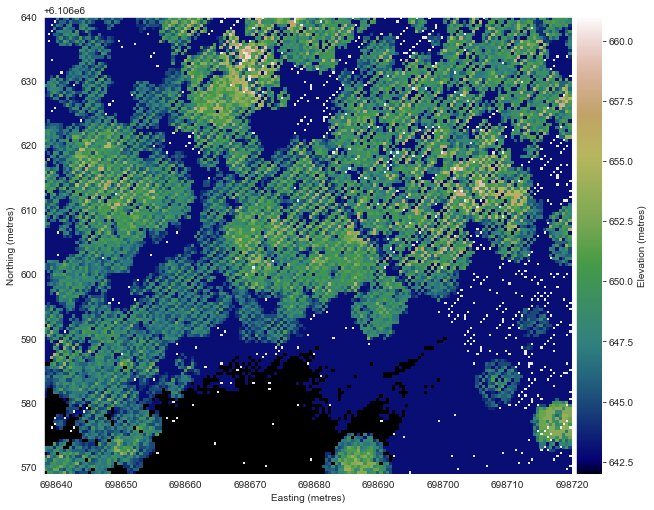

In [27]:
# plot the gridded data
plt.figure(figsize=(10,10))
plt.pcolormesh(x_binned,
               y_binned,
               z_binned,
               cmap="gist_earth")
plt.axis('equal')

# label the axes
plt.xlabel('Easting (metres)')
plt.ylabel('Northing (metres)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Elevation (metres)')

In [28]:
# put ground points in bins!
z_ground_binned, y_ground_binned, x_ground_binned = np.histogram2d(y_ground, x_ground,
                                                                   bins=(y_grid_points,x_grid_points),
                                                                   weights=z_ground,
                                                                   normed=False)
g_counts, _, _ = np.histogram2d(y_ground, x_ground, bins=(y_grid_points,x_grid_points))

z_ground_binned = z_ground_binned/g_counts

/Users/adam/anaconda3/envs/anu-wald/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/adam/anaconda3/envs/anu-wald/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, 'Elevation (metres)')

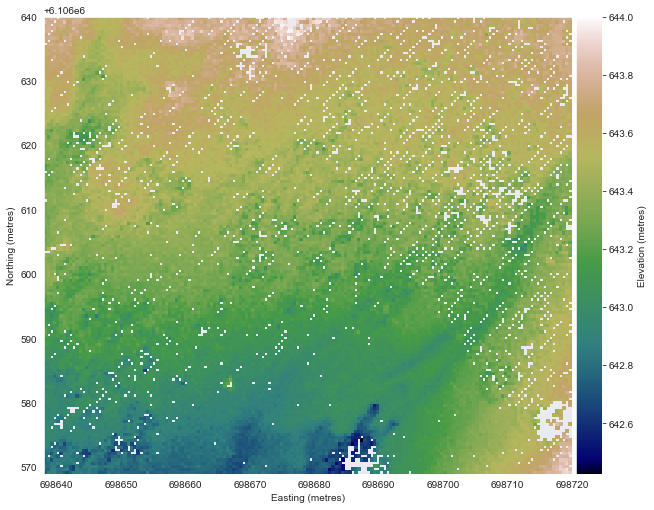

In [29]:
#plot the data!
plt.figure(figsize=(10,10))
plt.pcolormesh(x_ground_binned,
               y_ground_binned,
               z_ground_binned,
               cmap='gist_earth')
plt.axis('equal')

# label the axes
plt.xlabel('Easting (metres)')
plt.ylabel('Northing (metres)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Elevation (metres)')

In [30]:
#interpolate ground wherever ground is not

from scipy import interpolate

xv, yv = np.meshgrid(x_grid_points[:-1], y_grid_points[:-1])
z_ground_interp = interpolate.griddata((x_ground, y_ground), z_ground, (xv, yv), method='nearest')


Text(15.375, 0.5, 'Count')

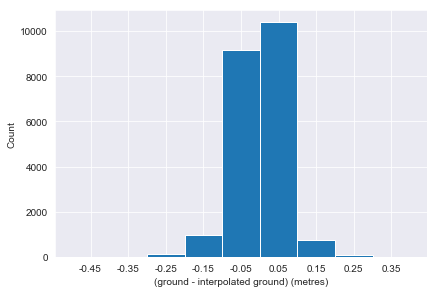

In [31]:
# check how good our interpolation is - our interpolated points should fall near LIDAR uncertainty limits,
# which, depending on the survey, may be up to +- 0.3 m

# here, we see that most of our interpolated points are +-5cm from the actual points - which is fine.

# generate bins
diff_hist_bins = np.arange(-0.5,0.5,0.100)
width = np.array([diff_hist_bins[i+1]-diff_hist_bins[i] for i in range(len(diff_hist_bins)-1)])
ind = np.array(diff_hist_bins[:-1])

#draw the histogram
fig, ax = plt.subplots()
n, bins, patches = plt.hist((z_ground_interp-z_ground_binned).ravel(), bins=diff_hist_bins)
ax.set_xticks(ind + width/2)
ax.set_xticklabels(diff_hist_bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

fig.tight_layout()
plt.xlabel('(ground - interpolated ground) (metres)')
plt.ylabel('Count')

Text(0, 0.5, 'Elevation (metres)')

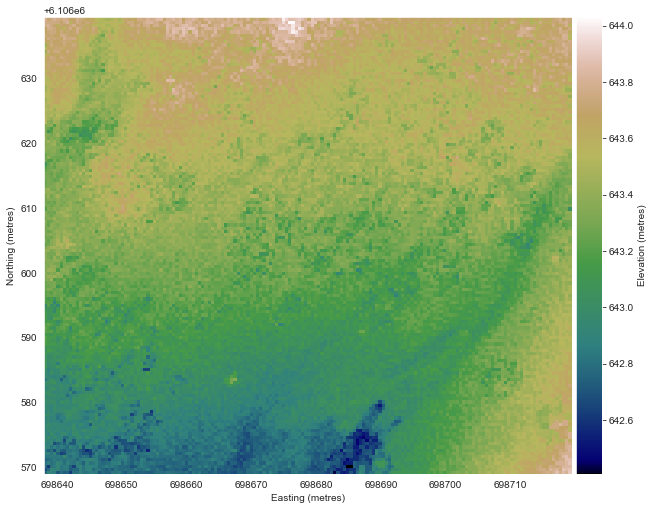

In [32]:
# plot interpolated heights for ground
plt.figure(figsize=(10,10))
plt.pcolormesh(xv, yv,
               z_ground_interp,
               cmap='gist_earth')
plt.axis('equal')

# label the axes
plt.xlabel('Easting (metres)')
plt.ylabel('Northing (metres)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Elevation (metres)')

### Bin the trees

In [33]:
# put points in bins!
z_trees_binned, y_trees_binned, x_trees_binned = np.histogram2d(y_trees, x_trees,
                                                                bins=(y_grid_points,x_grid_points),
                                                                weights=z_trees,
                                                                normed=False)
counts_t, _, _ = np.histogram2d(y_trees, x_trees, bins=(y_grid_points,x_grid_points))

z_trees_binned = z_trees_binned/counts_t

np.nanmin(z_trees_binned)

/Users/adam/anaconda3/envs/anu-wald/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/adam/anaconda3/envs/anu-wald/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


642.86

Text(0, 0.5, 'Elevation (metres)')

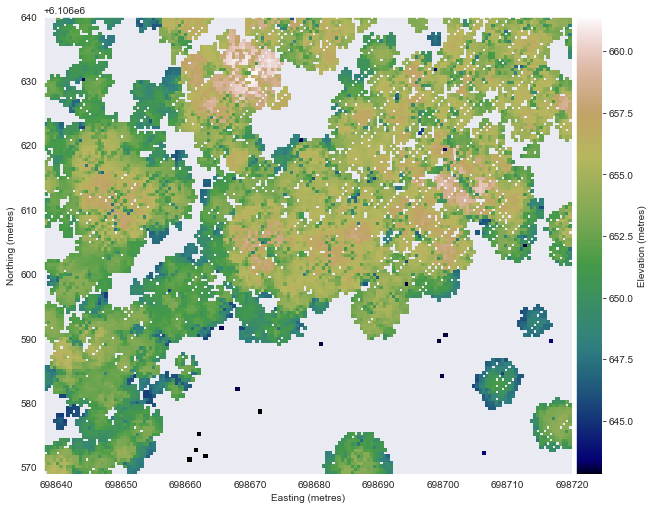

In [34]:
# plot the trees
plt.figure(figsize=(10,10))
plt.pcolormesh(x_trees_binned,
               y_trees_binned,
               z_trees_binned,
               cmap='gist_earth')
plt.axis('equal')

# label the axes
plt.xlabel('Easting (metres)')
plt.ylabel('Northing (metres)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Elevation (metres)')

### Normalising tree heights

Once we have a ground and tree map on a common grid, we subtract ground height from tree height:

In [35]:
z_trees_height = z_trees_binned - z_ground_interp

...and now we can map trees as 'tree height'

Text(0, 0.5, 'Tree height (metres)')

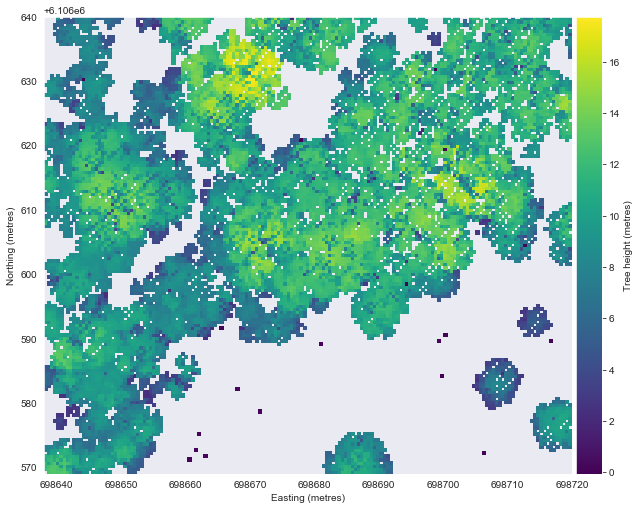

In [36]:
plt.figure(figsize=(10,10))
plt.pcolormesh(x_trees_binned,
               y_trees_binned,
               z_trees_height,
               cmap='viridis')
plt.axis('equal')

# label the axes
plt.xlabel('Easting (metres)')
plt.ylabel('Northing (metres)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Tree height (metres)')

In [37]:
# check the minimum 'tree height' value
np.nanmin(z_trees_height)

-0.05999999999994543

In [38]:
# check the maximum 'tree height' value
np.nanmax(z_trees_height)

17.754999999999995

Text(20.75, 0.5, 'Count')

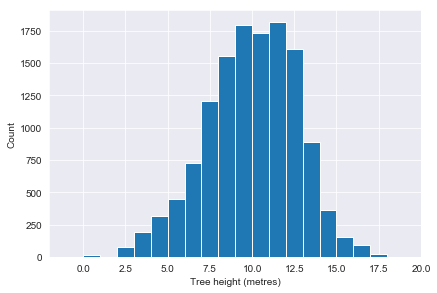

In [39]:
# check the distribution of tree heights

tree_hist_bins = np.arange(-1, 20, 1)
width = np.array([tree_hist_bins[i+1]-tree_hist_bins[i] for i in range(len(tree_hist_bins)-1)])
ind = np.array(tree_hist_bins[:-1])

#create the histogram plot
fig, ax = plt.subplots()
n, bins, patches = plt.hist(z_trees_height.ravel(), bins=tree_hist_bins)
fig.tight_layout()
plt.xlabel('Tree height (metres)')
plt.ylabel('Count')

In [40]:
# this is a bit haxxy - we're unpacking the grid coordinates to 1D arrays of X and Y coordinates for a 3D scatterplot
# for these data, it's easier to see what's happening in a scatterplot than in a surface or mesh plot
# ...but you can always try that and see.

x_gridded_coords = []
y_gridded_coords = []
for i in y_grid_points:
    for j in x_grid_points:
        y_gridded_coords.append(i)
        x_gridded_coords.append(j)
        
x_gridded_coords = np.array(x_gridded_coords)
y_gridded_coords = np.array(y_gridded_coords)
z_gridded_coords = z_trees_height.ravel()

x_gridded_coords = x_gridded_coords[np.where(np.isfinite(z_gridded_coords))]
y_gridded_coords = y_gridded_coords[np.where(np.isfinite(z_gridded_coords))]
z_gridded_coords = z_gridded_coords[np.where(np.isfinite(z_gridded_coords))]

#### Quick python note

We've used `ravel` a couple of times here - it's a Numpy convenience function which returns a flattened (1D) array from, in this case, a 2D grid. Read more [here](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.ravel.html#numpy.ravel)

Text(0.5, 0, 'Elevation (metres)')

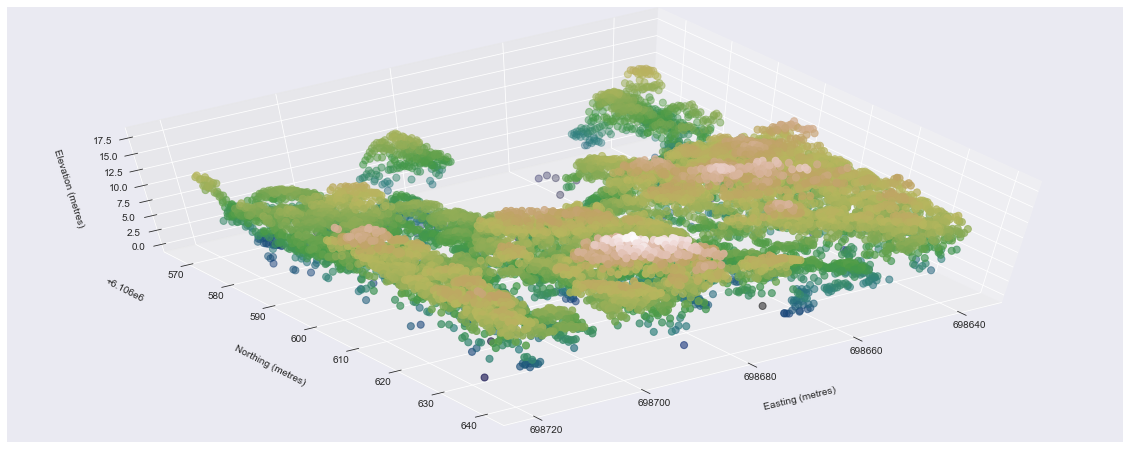

In [41]:
# now we can look at gridded trees in 3D
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_gridded_coords,
           y_gridded_coords,
           z_gridded_coords,
           c=z_gridded_coords,
           s=50, cmap='gist_earth')
ax.view_init(60, 55)

# label the axes
ax.set_xlabel("Easting (metres)", labelpad=30)
ax.set_ylabel("Northing (metres)", labelpad=30)
ax.set_zlabel("Elevation (metres)", labelpad=15)

## Tree height mapping summary

Using classified (labelled) LiDAR, we can relatively easily map tree heights. Now we have relative heights of trees, we can also start to look at other forest structures - for example the density of points in horizontal slices through the data at various tree heights.

Let's take a look at what happens between 6 and 7 metres above ground

In [42]:
# let's slice the data between 6 and 7m, and see what's there.
tree_hag = z_gridded_coords

z_slice = tree_hag[((tree_hag > 6) & (tree_hag < 7))]
x_slice = x_gridded_coords[((tree_hag > 6) & (tree_hag < 7))]
y_slice = y_gridded_coords[((tree_hag > 6) & (tree_hag < 7))]

Text(0, 0.5, 'Tree height (metres)')

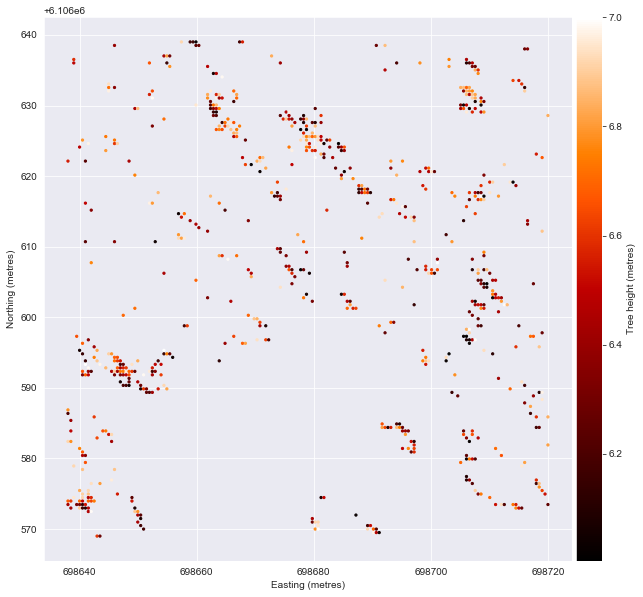

In [43]:
fig = plt.figure(figsize=(10,10))
plt.scatter(x_slice,
           y_slice,
           c=z_slice,
           s=5, cmap='gist_heat')

# label axes
plt.xlabel('Easting (metres)')
plt.ylabel('Northing (metres)')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Tree height (metres)')

...and we can't really see much below the canopy. Why is this? What structures does airborne LiDAR focus on?

This is a really simple method of computing height above ground - in practice the use of point neighbourhood analysis can remove the rasterisation step - for example developing a KD-Tree using ground points, and searching for the nearest 'no ground' points to given neighbourhoods of points.

As an example, we can see that the lowest point in tree heights is around -0.3 m. For a rigorous analysis we'd want to do better, or at least understand why that is the case. In this test, our interpolation of ground points is not necessarily accurate, and we haven't checked for misclassified 'trees'.

## Writing data out to use elsewhere

Many GIS applications depend on rasterised derivatives from point cloud data. We can accomplish that here - and let the applications run from there, with established workflows and user interfaces.

We've already 'rasterised' points to make tree maps - let's go another step and write out some of the gridded data to a GeoTIFF - which can be imported into (for example) QGIS or ArcGIS. We will introduce one more convenience library - RasterIO - to export a GeoTIFF.

Material on using RasterIO is adapted from: https://rasterio.readthedocs.io/en/latest/quickstart.html#creating-data

In [44]:
from rasterio.transform import from_origin

In [45]:
geotransform = from_origin(np.min(x_gridded_coords), np.max(y_gridded_coords), cellsize, cellsize)

In [46]:
with rasterio.open('./data/treeheights-airborne.tif', 'w', driver='GTiff',
                             height=y_bins, width=x_bins,
                              count=1, dtype='float64',
                              transform=geotransform,
                             crs='EPSG:28355') as dataset:
    dataset.write(np.flip(z_trees_height,0), 1)

Loading your data in QGIS or ArcGIS, and adding the WMTS layer from ACTMAPi's 2015 imagery server, you should get something like the image below (coloured using the Viridis colour scale in QGIS). Don't forget the coordinate reference system in EPSG code is **EPSG:28355**

Imagery server: http://data.actmapi.act.gov.au/arcgis/rest/services/actmapi/imagery2012mga/MapServer/WMTS/1.0.0/WMTSCapabilities.xml

![tree height in QGIS](./data/tree-heights-airborne.jpg)

## Tree data from ground-based LiDAR

In this exercise we visualise some ground-based LiDAR to assess how it might be used differently from, or in conjunction with, airborne LiDAR.

The main point here is to assess how ground based LiDAR might fit different analytical tasks.

As a convenience, we've supplied a LAS file with elevations already set to 'height above ground'

In [47]:
# read in the Zebedee file

zebedee = laspy.file.File('../data/zebedee-georef-classified-hag.las', mode = 'r')
zeb_header = zebedee.get_header()

In [48]:
# what LAS format 'minor version' is this file? Recall that in 2018, all LAS data has 'major version' of 1.

zeb_header.minor_version

2

In [49]:
# What point format is this file?
# (what point format was the airborne file?)

zeb_header.dataformat_id

3

In [50]:
# what things are recorded for each point?

pointformat = zebedee.point_format
for spec in pointformat:
    print(spec.name)

X
Y
Z
intensity
flag_byte
raw_classification
scan_angle_rank
user_data
pt_src_id
gps_time
red
green
blue


In [51]:
#what do zebedee points look like?
zebedee.points

array([((69869328, 610658803, 0, 0, 9, 2, 0, 0, 0, 0., 0, 0, 0),),
       ((69869328, 610658808, 0, 0, 9, 2, 0, 0, 0, 0., 0, 0, 0),),
       ((69869329, 610658809, 0, 0, 9, 2, 0, 0, 0, 0., 0, 0, 0),), ...,
       ((69868586, 610658191, 0, 0, 9, 2, 0, 0, 0, 0., 0, 0, 0),),
       ((69868561, 610658162, 0, 0, 9, 2, 0, 0, 0, 0., 0, 0, 0),),
       ((69868420, 610658002, 0, 0, 9, 2, 0, 0, 0, 0., 0, 0, 0),)],
      dtype=[('point', [('X', '<i4'), ('Y', '<i4'), ('Z', '<i4'), ('intensity', '<u2'), ('flag_byte', 'u1'), ('raw_classification', 'u1'), ('scan_angle_rank', 'i1'), ('user_data', 'u1'), ('pt_src_id', '<u2'), ('gps_time', '<f8'), ('red', '<u2'), ('green', '<u2'), ('blue', '<u2')])])

[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10')]

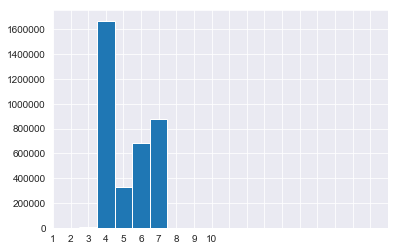

In [52]:
#are Zebedee data classified?

fig, ax = plt.subplots()
n, bins, patches = plt.hist(zebedee.Classification, bins=class_hist_bins)
ax.set_xticks(ind + width/2)
ax.set_xticklabels(class_hist_bins)

Text(20.75, 0.5, 'Count')

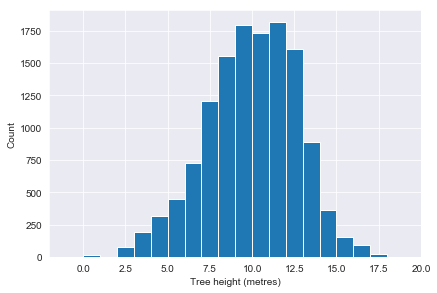

In [53]:
tree_hist_bins = np.arange(-1, 20, 1)
width = np.array([tree_hist_bins[i+1]-tree_hist_bins[i] for i in range(len(tree_hist_bins)-1)])
ind = np.array(tree_hist_bins[:-1])

#create the histogram plot
fig, ax = plt.subplots()
n, bins, patches = plt.hist(z_trees_height.ravel(), bins=tree_hist_bins)
fig.tight_layout()
plt.xlabel('Tree height (metres)')
plt.ylabel('Count')

Text(0.5, 0, 'Height above ground (metres)')

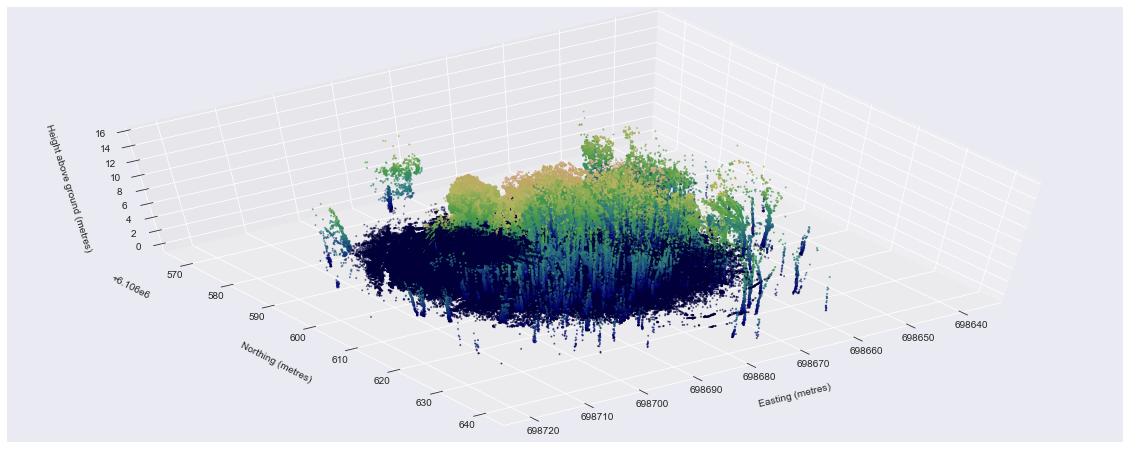

In [54]:
# and in 3D - you can see a lot of detail that isn't present in airborne data - especially under the canopy

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(zebedee.x,
           zebedee.y,
           zebedee.z,
           c=zebedee.z, 
           cmap='gist_earth', s=1)
ax.view_init(60, 55)

# label the axes
ax.set_xlabel('Easting (metres)', labelpad=25)
ax.set_ylabel('Northing (metres)', labelpad=25)
ax.set_zlabel('Height above ground (metres)', labelpad=15)

## Forest slices from ground based LiDAR

The next plot shows ground-based LiDAR sampled between 6 and 7 metres. What structural differences can you see? 

How is it different from the 'slice' of data in the airborne LiDAR dataset?

Text(0, 0.5, 'Tree height (metres)')

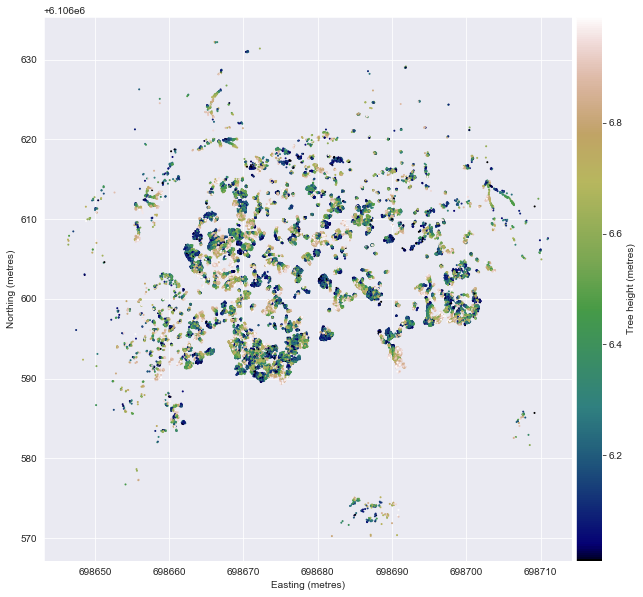

In [55]:
fig = plt.figure(figsize=(10,10))
plt.scatter(zebedee.x[((zebedee.z > 6) & (zebedee.z < 7))],
           zebedee.y[((zebedee.z > 6) & (zebedee.z < 7))],
           c=zebedee.z[((zebedee.z > 6) & (zebedee.z < 7))], 
           cmap='gist_earth', s=1)

# label the axes
plt.xlabel('Easting (metres)')
plt.ylabel('Northing (metres)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Tree height (metres)')

## Comparing tree heights from ground and airborne data

Let's grid our patch of ground-based LiDAR into the same system as the airborne data, and compare the two.

We recycle the grid cell size from gridding the airborne data.

In [56]:
#extract ground points
x_ground_zeb = zebedee.x[np.where(zebedee.Classification == 2)]
y_ground_zeb = zebedee.y[np.where(zebedee.Classification == 2)]
z_ground_zeb = zebedee.z[np.where(zebedee.Classification == 2)]

In [57]:
#extract trees
x_trees_zeb = zebedee.x[np.where(zebedee.Classification == 5)]
y_trees_zeb = zebedee.y[np.where(zebedee.Classification == 5)]
z_trees_zeb = zebedee.z[np.where(zebedee.Classification == 5)]

In [58]:
#set up our grid
box_dimensions = np.array(zebedee.header.max[:]) - np.array(zebedee.header.min[:])

# how many bins in X and Y?
x_bins_z=int(np.ceil(box_dimensions[0]+1) * (1/cellsize))
y_bins_z=int(np.ceil(box_dimensions[1]+1) * (1/cellsize))

# create some histogram bins
x_grid_points_z = np.linspace(np.floor(zebedee.header.min[0]),np.ceil(zebedee.header.max[0]),x_bins_z)
y_grid_points_z = np.linspace(np.floor(zebedee.header.min[1]),np.ceil(zebedee.header.max[1]),y_bins_z)


In [59]:
#rasterise and write out a file of tree data

# bin point into a 2D grid - using a 2D histogram!

z_trees_binned_z, y_trees_binned_z, x_trees_binned_z = np.histogram2d(y_trees_zeb, x_trees_zeb,
                                                                bins=(y_grid_points_z,x_grid_points_z),
                                                                weights=z_trees_zeb,
                                                                normed=False)
counts_t, _, _ = np.histogram2d(y_trees_zeb, x_trees_zeb, bins=(y_grid_points_z,x_grid_points_z))

z_trees_binned_z = z_trees_binned_z/counts_t

/Users/adam/anaconda3/envs/anu-wald/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/adam/anaconda3/envs/anu-wald/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Tree height (metres)')

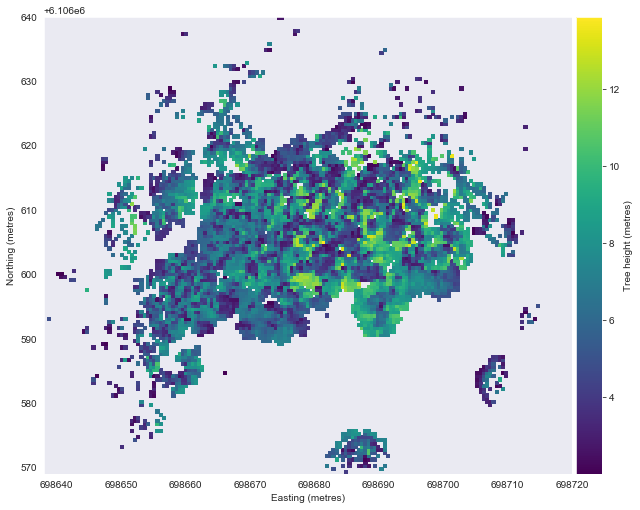

In [60]:
plt.figure(figsize=(10,10))
plt.pcolormesh(x_trees_binned_z, y_trees_binned_z, z_trees_binned_z, cmap="viridis")
plt.axis('equal')

# label the axes
plt.xlabel('Easting (metres)')
plt.ylabel('Northing (metres)')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = plt.colorbar(cax=cax)
cbar.ax.set_ylabel('Tree height (metres)')

In [61]:
z_geotransform = from_origin(np.min(x_gridded_coords), np.max(y_gridded_coords), cellsize, cellsize)

In [62]:
with rasterio.open('./data/treeheights-zeb.tif', 'w', driver='GTiff',
                             height=y_bins_z, width=x_bins_z,
                              count=1, dtype='float64',
                              transform=geotransform,
                             crs='EPSG:28355') as dataset:
    dataset.write(np.flip(z_trees_binned_z,0), 1)

## View your output

In QGIS or ArcGIS, open the file you just wrote in your existing project with an imagery layer underneath. With a little styling, it might look like this. Here, Zebedee treeheights are in purple (Magma colourmap in QGIS)

![tree height in QGIS](./data/tree-heights-zeb.jpg)

## Wrapup

We've covered a lot of ground here! To recap, we have:
- using LASpy, read an ASPRS LAS file into an array-like object
- inspected a LAS file header to discover some attributes of the data
- used data labels (classifications) to map ground, and trees
- gridded irregular points into 2D grids
- interpolated ground points where none exist
- derived tree heights
- exported data to a format useable in other GIS systems
- inspected airborne and ground-based LIDAR
- discussed differences between the two strategies for data collection



## Extension exercises


If you're looking for more to do, try:
- extract some data from Geoscience Australia's ELVIS system: or OpenTopography: and repeat some of these exercises (take care to keep your data small-ish, you'll be waiting a long time to plot more than a few hundred thousand points)
- create a tree height difference map in this notebook with plain Numpy, and plot the map
- discuss anything and everything in this tutorial with your tutor, including alternative tools for these tasks
- copy this notebook and see how many repetetive tasks you can turn into functions
- try to visualise tree trunks along with canopy data - a clue is given below:

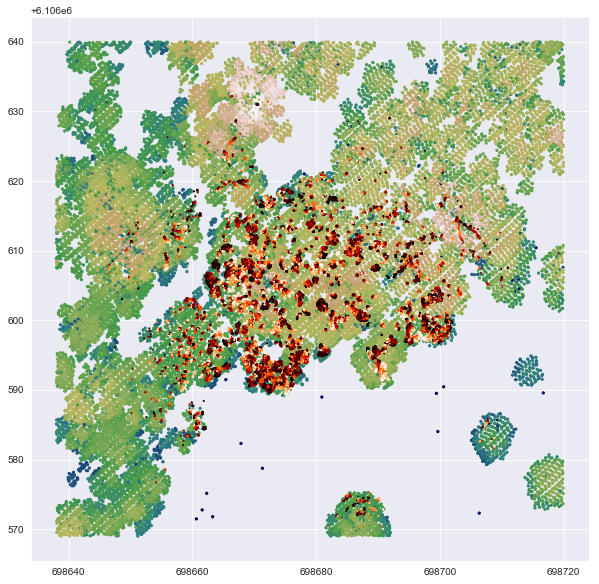

In [64]:
# plot canopy points from airborne data, and possible trunk locations from ground-based data:

fig = plt.figure(figsize=(10,10))
plt.scatter(x_trees,
           y_trees,
           c=z_trees,
           s=5, cmap='gist_earth')

plt.scatter(zebedee.x[((zebedee.z > 6) & (zebedee.z < 7))],
           zebedee.y[((zebedee.z > 6) & (zebedee.z < 7))],
           c=zebedee.z[((zebedee.z > 6) & (zebedee.z < 7))], 
           cmap='gist_heat', s=1)


## Processing LIDAR for real

This notebook shows some Pythonic functionality for looking at LAS data, and exploratory analysis/visualisation. For serious number crunching there are better tools:

- PDAL, the point data abstraction library - see http://pdal.io. This is a c++ library with python bindings, which can be used for small or large scale point cloud data processing. It's key functions are a huge range of input and output options, and a structure designed for repeatable processing pipelines. See, for example: https://github.com/adamsteer/f4g-oceania-pdal

- LAStools, a part-open, part-closed toolkit for LIDAR processing: https://rapidlasso.com/lastools/. Many useful LAStools functions are free to use - however, some key analytical capabilities require a license.

While you are free to develop fully pythonic methods of processing points based on what you see here, a lot of the wheels you want to build are probably already made, and tested in huge data processing tasks already. It pays to look around and assess options before committing to a specific toolkit for a task.